In [1]:
!pip install -q evaluate

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import cv2
import tifffile
from pathlib import Path
import shutil
import concurrent.futures
from sklearn.model_selection import train_test_split
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
from transformers import (
    SegformerForSemanticSegmentation, 
    TrainingArguments, Trainer, 
    SegformerImageProcessor)
from datasets import Dataset, Image
import evaluate
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = 12, 12

### Settings

In [5]:
DATA_DIR = Path('/kaggle/input')

In [6]:
# Pre-trained models
# MODEL_CHECKPOINT = 'nvidia/mit-b0'
# MODEL_CHECKPOINT = 'nvidia/mit-b1'
# MODEL_CHECKPOINT = 'nvidia/mit-b2'
# MODEL_CHECKPOINT = 'nvidia/mit-b3'
MODEL_CHECKPOINT = 'nvidia/mit-b4'
# MODEL_CHECKPOINT = 'nvidia/mit-b5'
# MODEL_CHECKPOINT = 'nvidia/segformer-b4-finetuned-cityscapes-1024-1024'

VAL_SIZE = 0.15
BATCH_SIZE = 4
EPOCHS = 5
LR = 0.00008

IMG_SIZE = 512

### Data processing

In [7]:
images = list(DATA_DIR.glob('./*/*/*tif'))
images = [str(path) for path in images]
masks = [path.replace('_image', '_mask').replace('tif', 'png') for path in images]
print(f'{len(images)} images detected.')

768 images detected.


In [8]:
train_images, val_images, train_masks, val_masks = train_test_split(
    images, masks, test_size=VAL_SIZE, random_state=0, shuffle=True)
print(f'Train images: {len(train_images)}\nValidation images: {len(val_images)}')

Train images: 652
Validation images: 116


In [9]:
def create_dataset(image_paths, mask_paths):
    dataset = Dataset.from_dict({'pixel_values': image_paths,
                                 'label': mask_paths})
    dataset = dataset.cast_column('pixel_values', Image())
    dataset = dataset.cast_column('label', Image())
    return dataset


ds_train = create_dataset(train_images, train_masks)
ds_valid = create_dataset(val_images, val_masks)

In [10]:
# Image preprocessing native to the pretrained model.
feature_extractor = SegformerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

In [11]:
def apply_transforms(batch):
    images = [x for x in batch['pixel_values']]
    labels = [x for x in batch['label']]
    inputs = feature_extractor(images, labels)
    return inputs


ds_train.set_transform(apply_transforms)
ds_valid.set_transform(apply_transforms)

### Model

In [12]:
id2label = {0: 'background', 1: 'water'}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = SegformerForSemanticSegmentation.from_pretrained(
    MODEL_CHECKPOINT,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

Some weights of the model checkpoint at nvidia/mit-b4 were not used when initializing SegformerForSemanticSegmentation: ['classifier.weight', 'classifier.bias']
- This IS expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing SegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of SegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b4 and are newly initialized: ['decode_head.linear_c.0.proj.bias', 'decode_head.linear_c.1.proj.bias', 'decode_head.linear_c.2.proj.weight', 'decode_head.linear_c.1.proj.weight', 'decode_head.classifier.bias', 'decode_head.linear_

In [13]:
metric = evaluate.load('mean_iou')


def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        # scale the logits to the size of the label
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode='bilinear',
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        # currently using _compute instead of compute
        # see this issue for more info: https://github.com/huggingface/evaluate/pull/328#issuecomment-1286866576
        metrics = metric._compute(
                predictions=pred_labels,
                references=labels,
                num_labels=len(id2label),
                ignore_index=0,
                reduce_labels=feature_extractor.do_reduce_labels,
            )

        # add per category metrics as individual key-value pairs
        per_category_accuracy = metrics.pop("per_category_accuracy").tolist()
        per_category_iou = metrics.pop("per_category_iou").tolist()

        metrics.update({f"accuracy_{id2label[i]}": v for i, v in enumerate(per_category_accuracy)})
        metrics.update({f"iou_{id2label[i]}": v for i, v in enumerate(per_category_iou)})

        return metrics

In [14]:
training_args = TrainingArguments(
    'segformer_water_finetuned',
    learning_rate=LR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    save_total_limit=3,
    evaluation_strategy='steps',
    save_strategy='steps',
    save_steps=20,
    eval_steps=20,
    logging_steps=1,
    eval_accumulation_steps=5,
    load_best_model_at_end=True,
    push_to_hub=False,
    report_to='none'
)

In [15]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=ds_train,
    eval_dataset=ds_valid,
    compute_metrics=compute_metrics,
)

trainer.train()

TrainOutput(global_step=815, training_loss=0.04041458147012292, metrics={'train_runtime': 3478.9748, 'train_samples_per_second': 0.937, 'train_steps_per_second': 0.234, 'total_flos': 9.84403384247255e+17, 'train_loss': 0.04041458147012292, 'epoch': 5.0})

In [16]:
model.save_pretrained('segformer_water')

### Inference

In [17]:
id2label = {0: 'background', 1: 'water'}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)

model = SegformerForSemanticSegmentation.from_pretrained(
    'segformer_water',
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
)

feature_extractor = SegformerImageProcessor.from_pretrained(MODEL_CHECKPOINT)

Validation image #1


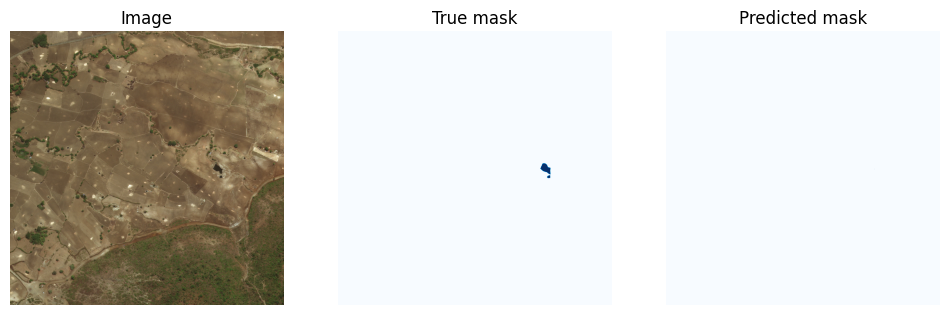

Validation image #2


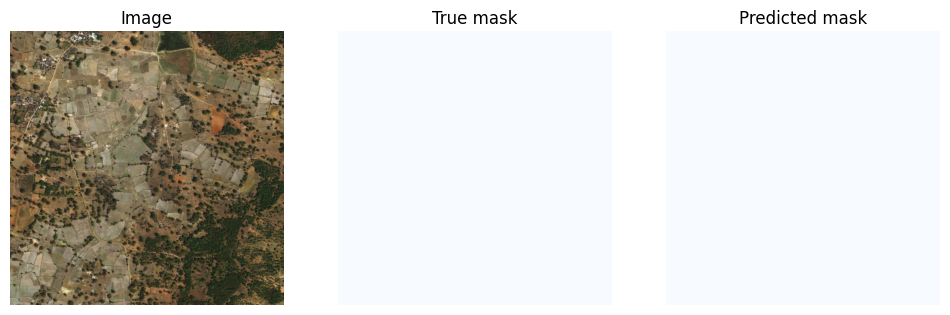

Validation image #3


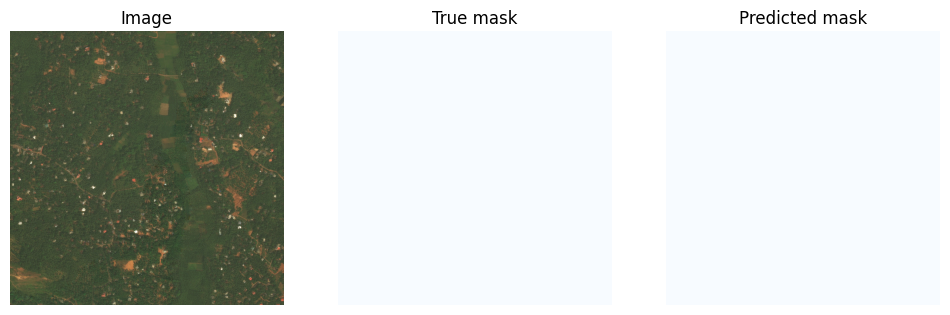

Validation image #4


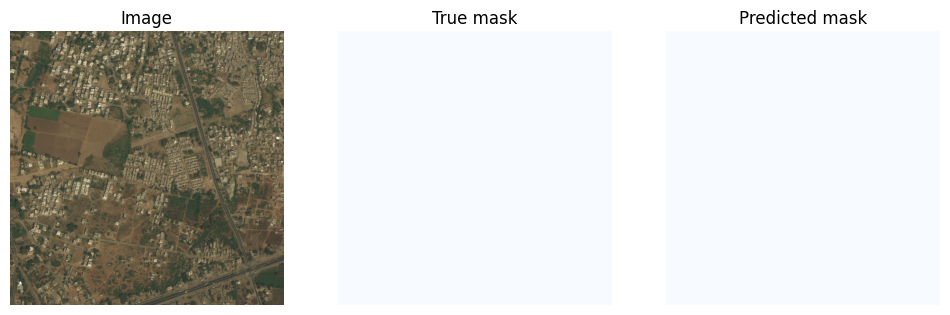

Validation image #5


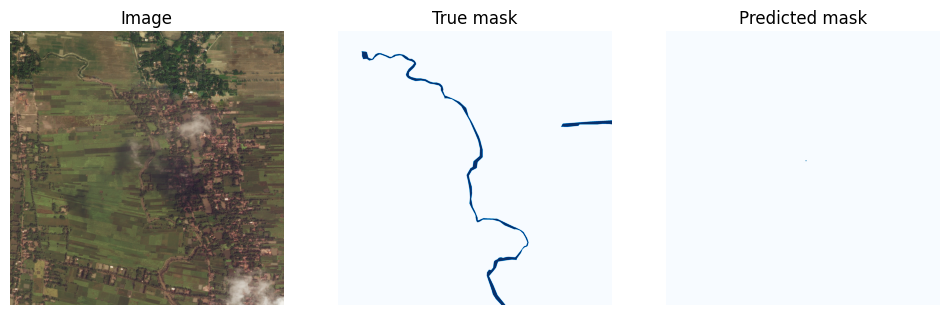

Validation image #6


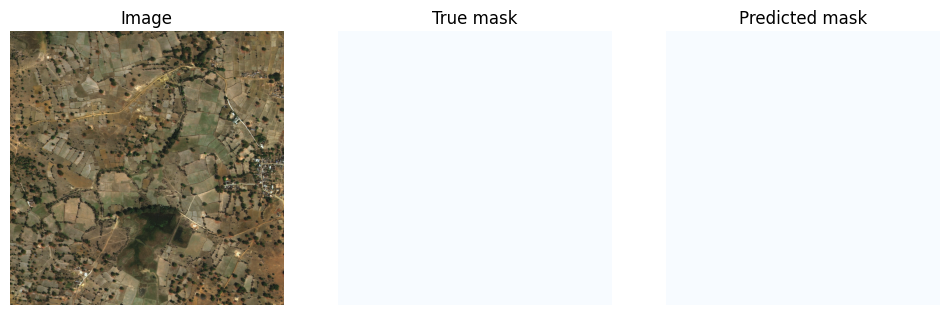

Validation image #7


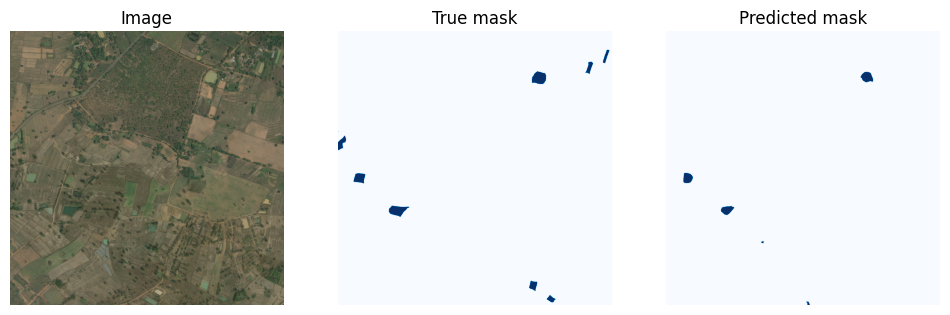

Validation image #8


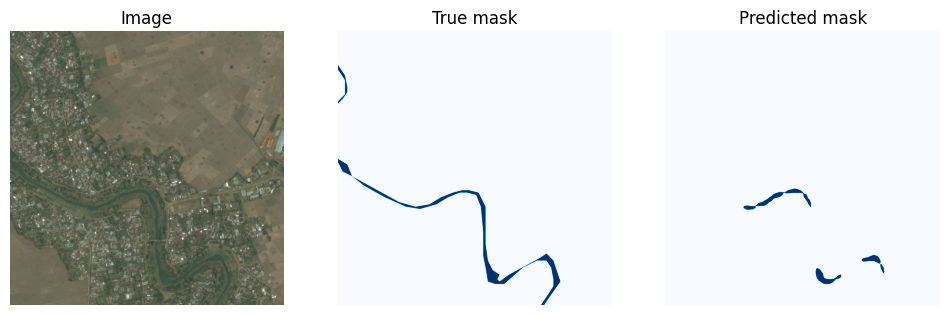

Validation image #9


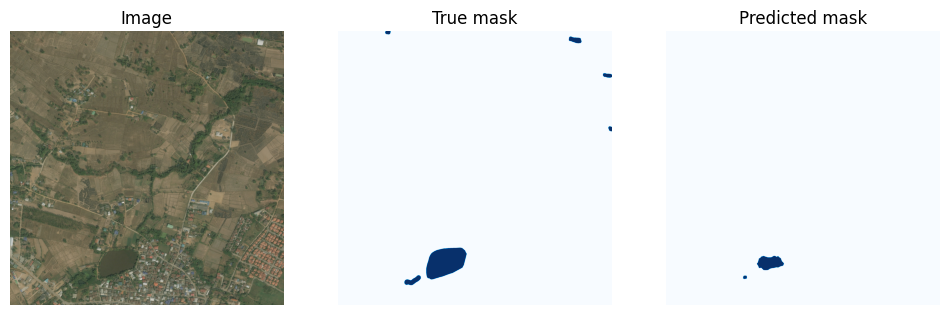

Validation image #10


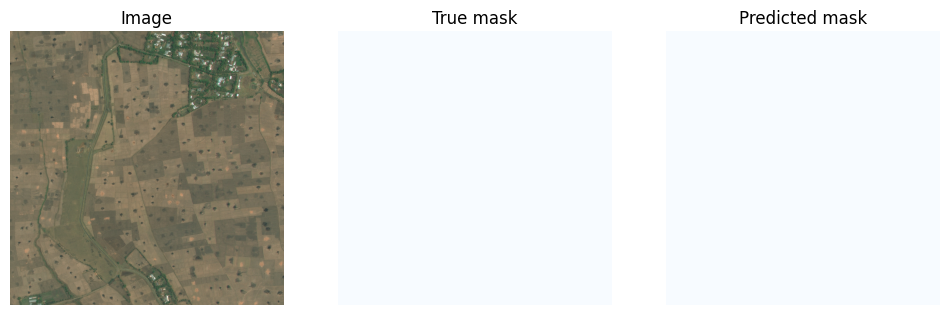

Validation image #11


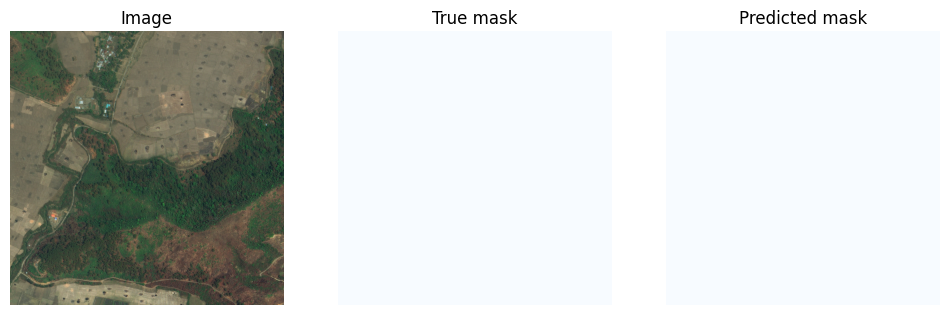

Validation image #12


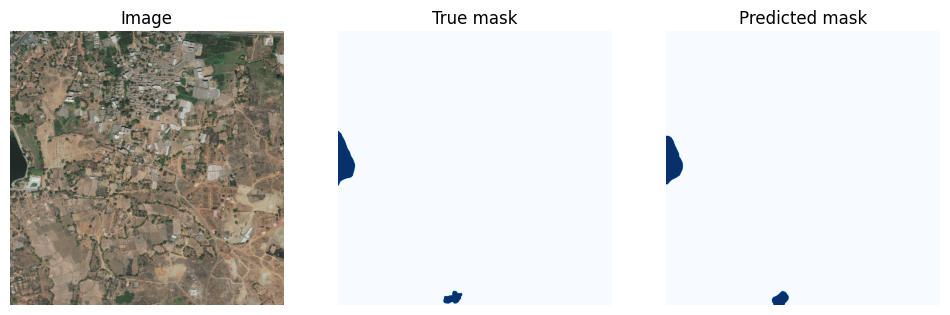

Validation image #13


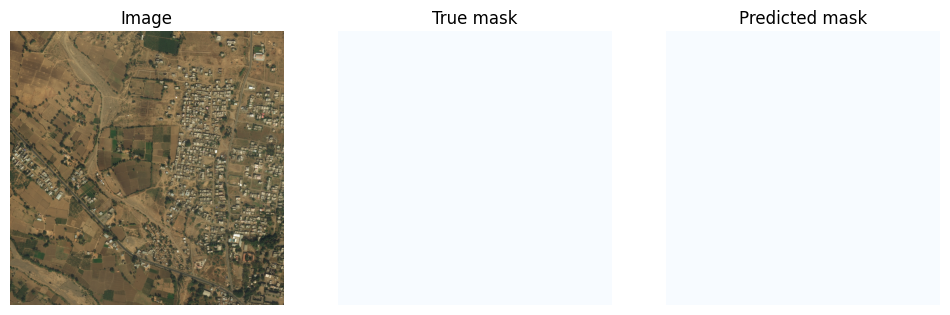

Validation image #14


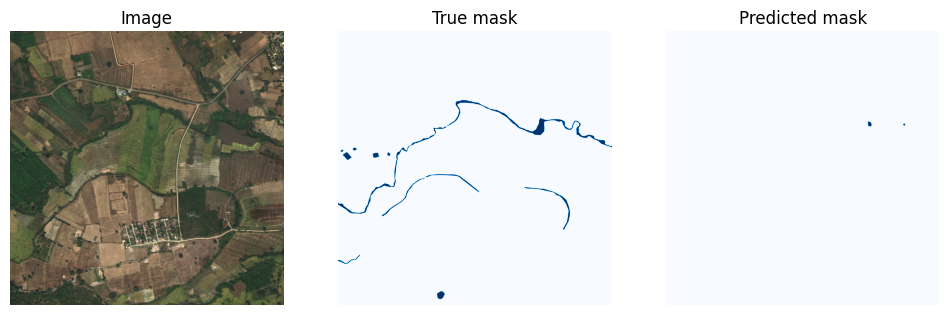

Validation image #15


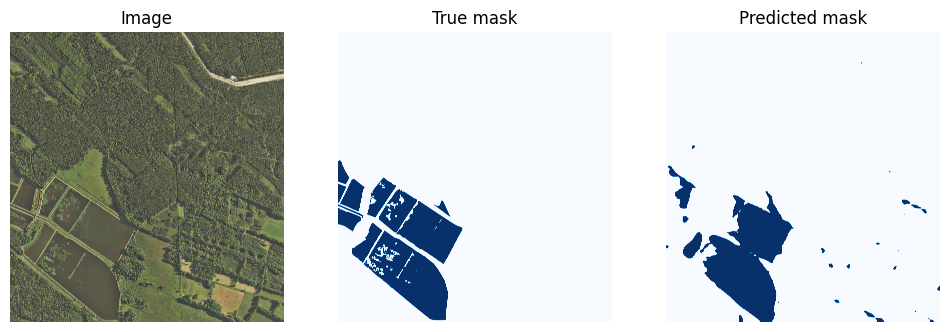

Validation image #16


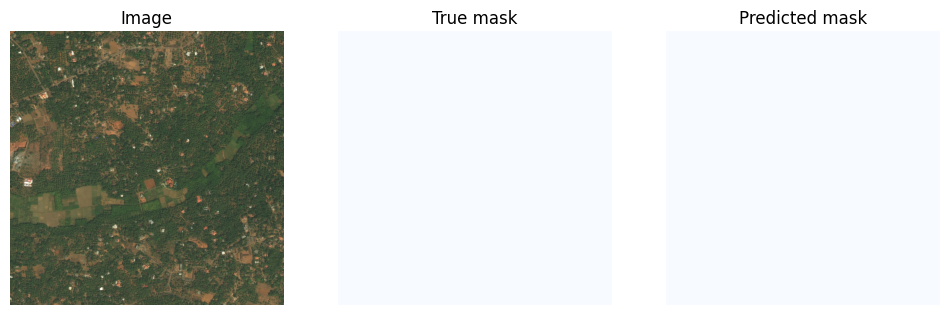

Validation image #17


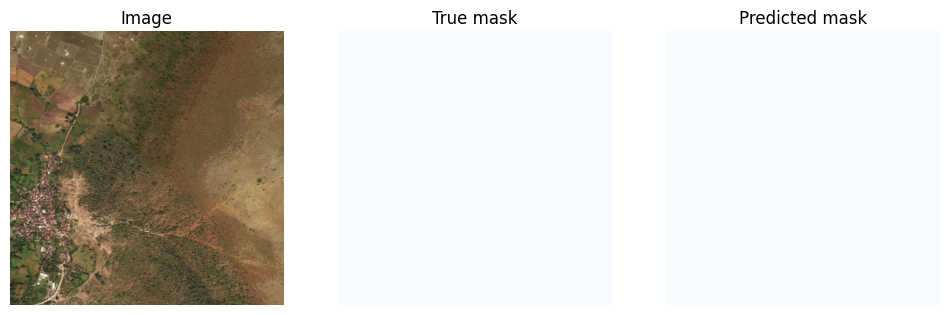

Validation image #18


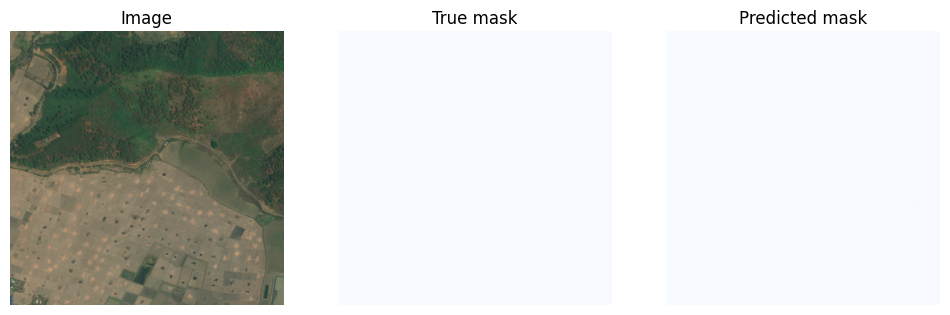

Validation image #19


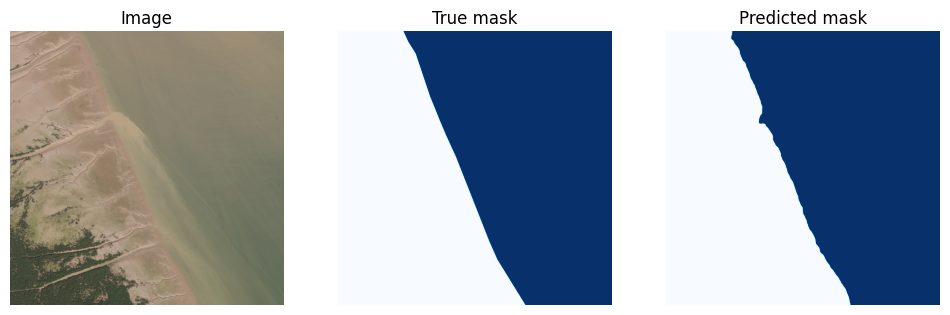

Validation image #20


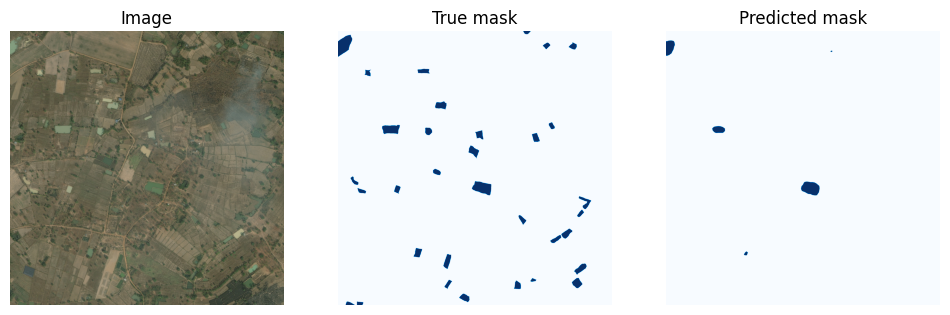

Validation image #21


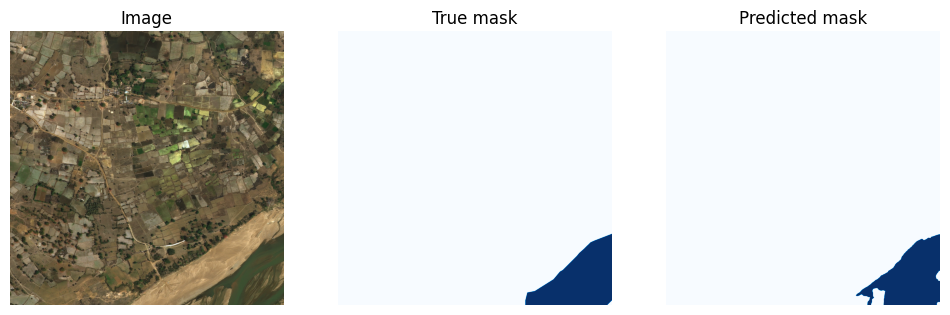

Validation image #22


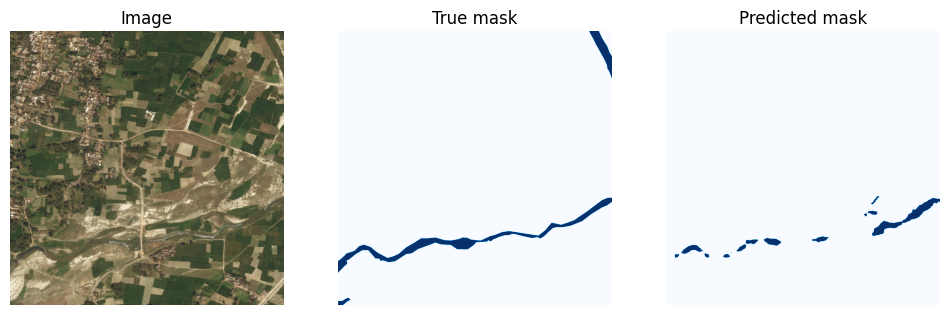

Validation image #23


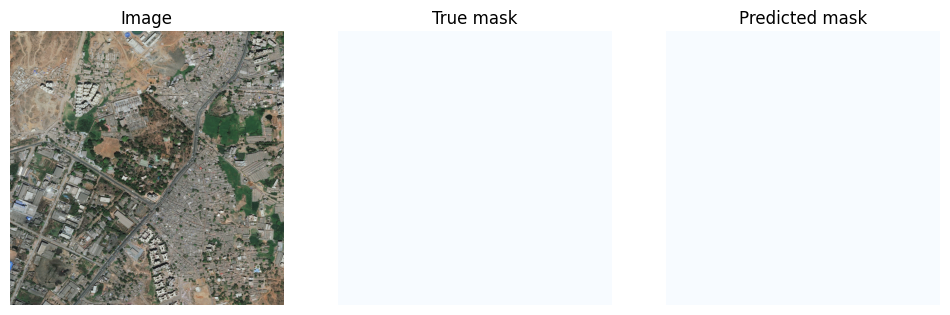

Validation image #24


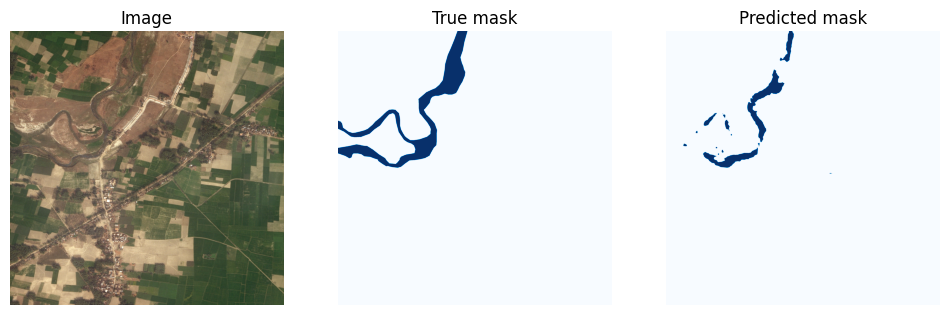

Validation image #25


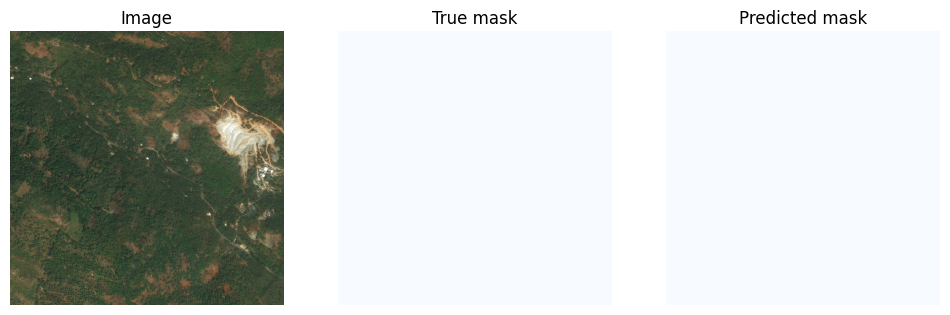

Validation image #26


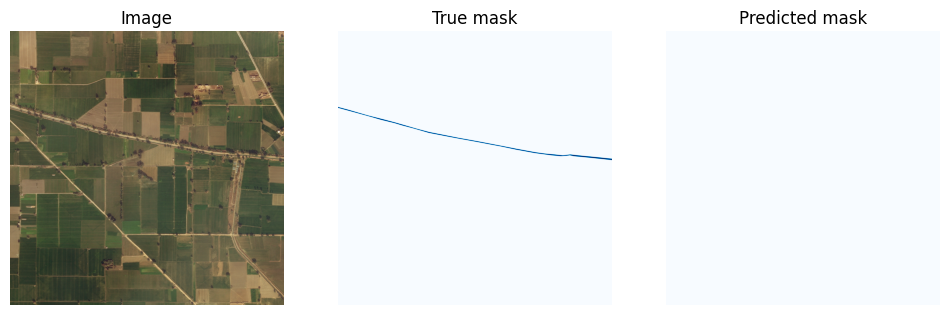

Validation image #27


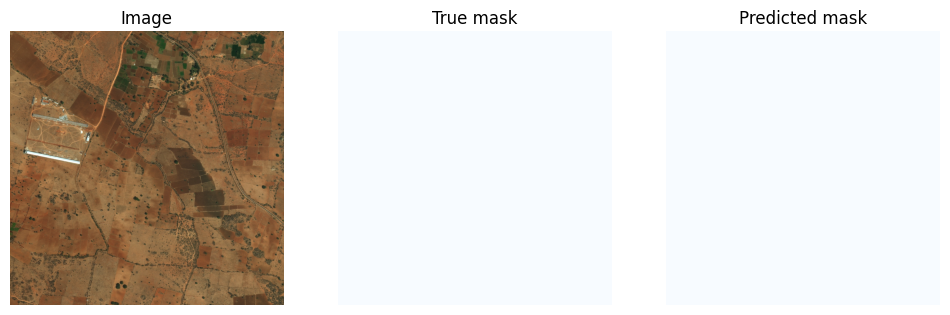

Validation image #28


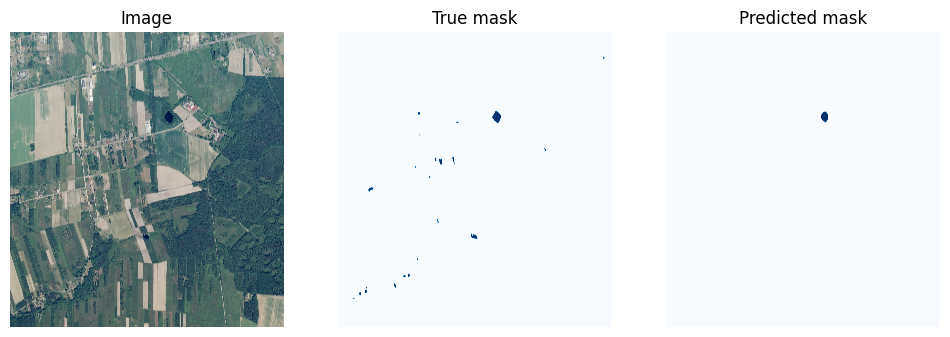

Validation image #29


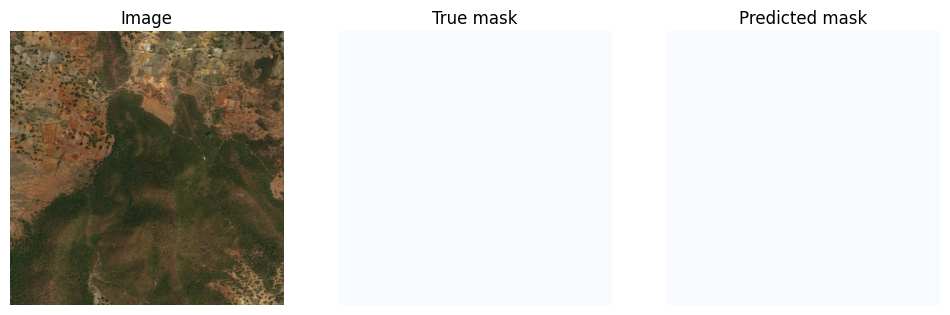

Validation image #30


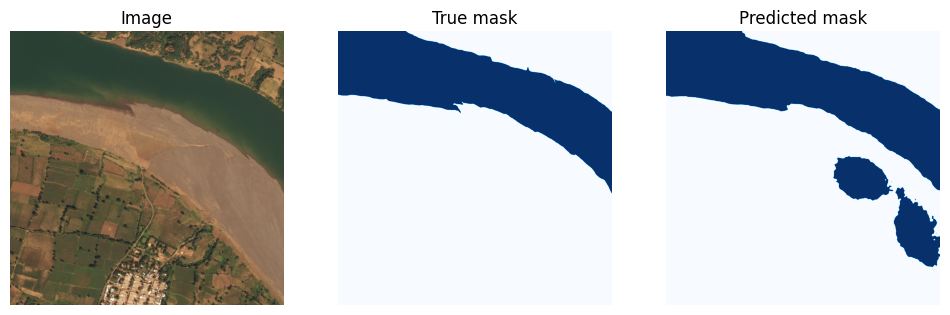

In [18]:
for i in range(30):
    image_path = val_images[i]
    mask_path = val_masks[i]
    
    image = tifffile.imread(image_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
    print(f'Validation image #{i + 1}')
    #print(mask)
    
    inputs = np.moveaxis(image, -1, 0)
    inputs = feature_extractor(images=image, return_tensors='pt')

    outputs = model(**inputs)
    logits = outputs.logits
    
    # Rescale logits to original image size
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.shape[:-1], # (height, width)
        mode='bilinear',
        align_corners=False
    )

    # Apply argmax on the class dimension
    pred_mask = upsampled_logits.argmax(dim=1)[0]
    
    
    fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3)
    
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('Off')
    
    #c = mask[:,:,None]

    #mask_3d = np.concatenate([c,c,c], axis=2).shape
    
    #ax2.imshow(image * mask_3d)
    ax2.imshow(mask, cmap='Blues')
    ax2.set_title('True mask')
    ax2.axis('Off')
    
    ax3.imshow(image)
    ax3.imshow(pred_mask, cmap='Blues')
    ax3.set_title('Predicted mask')
    ax3.axis('Off')
    plt.show()

In [ ]:
a = np.ones((2448,2448,3))
b = np.ones((2448,2448))

c = b[:,:,None]

np.concatenate([c,c,c], axis=2).shape